In [1]:
import pandas as pd
from glob import glob
from matplotlib import pyplot as plt
import os
import re
import numpy as np
from itertools import permutations
import requests
from matplotlib_venn import venn3, venn3_circles
import shutil
from plumbum.cmd import obabel
from rdkit import Chem, DataStructs
import math
import requests
from bs4 import BeautifulSoup
%matplotlib inline

In [2]:
docked_dir = glob('BDB_docked/*/')

In [3]:
print(f'number docked directories:\t{len(docked_dir)}')

number docked directories:	1597


In [4]:
full_docked_df = pd.DataFrame(columns=['Compound', 'Structure File', 'Surflex Score', 'Ki(nM)', 'IC50(nM)',
       'Kd(nM)'])
bad_prots = []
for dd in docked_dir:
    protein = dd.split('/')[-2].split('_')[0]
    if os.path.isfile(f'{dd}{protein}.csv'):  
        full_docked_df = full_docked_df.append(pd.read_csv(f'{dd}{protein}.csv'),ignore_index=True)
    else:
        bad_prots.append(f'{dd}{protein}.csv')

In [5]:
full_docked_df['Receptor'] = full_docked_df['Structure File'].apply(lambda x: re.findall('(?<=surflex/)[A-Z\d]{4}(?=_)',x)[0])
full_docked_df['Ligand ID'] = full_docked_df['Structure File'].apply(lambda x: x.split('.')[-2].split('_')[-1])

### IC50 is most prevalent
Therefore we subset the whole frame to those ligands with IC50 measurements

In [6]:
ic50_avail_df = full_docked_df[full_docked_df['IC50(nM)'].notna()]

In [7]:
print('{} unique receptors'.format(len(ic50_avail_df['Receptor'].unique())))
print('{} unique recptor-ligand pairs'.format(len(ic50_avail_df.drop_duplicates(subset=['Receptor','Ligand ID']))))

971 unique receptors
6602 unique recptor-ligand pairs


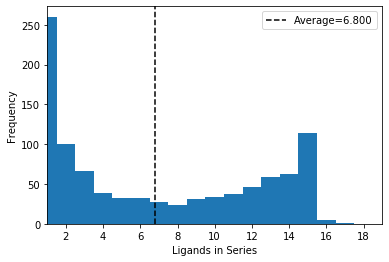

In [34]:
ic50_rm_lig_gp = ic50_avail_df.groupby('Receptor')
lig_counts = ic50_rm_lig_gp.count()['Ligand ID']
plt.hist(lig_counts,bins=np.arange(1,max(lig_counts),1),align='left')
plt.axvline(x=np.mean(lig_counts),label=f'Average={np.mean(lig_counts):.3f}',color='k',linestyle='--')
plt.xlabel('Ligands in Series')
plt.xlim([1,max(lig_counts)])
plt.ylabel('Frequency')
plt.legend()

In [9]:
more_than_one_IC50_bool = ic50_avail_df['IC50(nM)'].apply(lambda x: len(str(x).split(';')) > 1)
ic50_rm_mt1_meas = ic50_avail_df[~more_than_one_IC50_bool].copy()
ic50_rm_mt1_meas['IC50(nM)'] = ic50_rm_mt1_meas['IC50(nM)'].apply(lambda x: float(x.strip('><')) if isinstance(x,str) else x)
ic50_mt1_meas = (ic50_avail_df[more_than_one_IC50_bool].reset_index())

## Getting the median 
ic50_mt1_meas['IC50(nM)'] = ic50_mt1_meas['IC50(nM)'].apply(lambda x: np.median([float(val.strip('><')) for val in x.split(';')]))

In [10]:
all_ic50_meas = ic50_rm_mt1_meas.append(ic50_mt1_meas)
all_ic50_gp = all_ic50_meas.groupby('Receptor')
all_ic50_final = all_ic50_gp.filter(lambda x: len(x) > 1) ## remove groups with less than 2 ligands

Text(0.5, 0, 'pIC50')

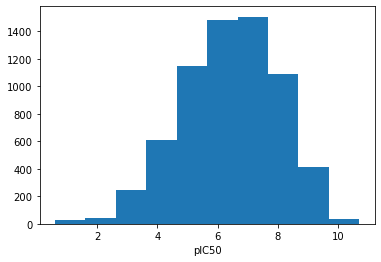

In [11]:
plt.hist(-np.log10(all_ic50_meas['IC50(nM)']*(1E-9)))
plt.xlabel('pIC50')

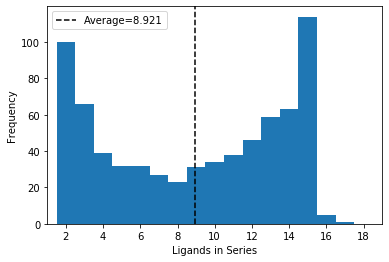

In [35]:
ic50_rm_lig_gp = all_ic50_final.groupby('Receptor')
lig_counts = ic50_rm_lig_gp.count()['Ligand ID']
plt.hist(lig_counts,bins=np.arange(1,max(lig_counts),1),align='left')
plt.axvline(x=np.mean(lig_counts),label=f'Average={np.mean(lig_counts):.3f}',color='k',linestyle='--')
plt.xlabel('Ligands in Series')
plt.xlim([1,max(lig_counts)])
plt.ylabel('Frequency')
plt.legend()

### Ki is next most prevalent
Therefore we subset the whole frame to those ligands with Ki measurements

In [13]:
ki_avail_df = full_docked_df[full_docked_df['Ki(nM)'].notna()]

In [14]:
print('{} unique receptors'.format(len(ki_avail_df['Receptor'].unique())))
print('{} unique recptor-ligand pairs'.format(len(ki_avail_df.drop_duplicates(subset=['Receptor','Ligand ID']))))

474 unique receptors
2415 unique recptor-ligand pairs


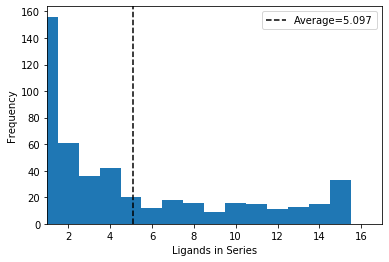

In [36]:
ki_avail_df_gp = ki_avail_df.groupby('Receptor')
lig_counts = ki_avail_df_gp.count()['Ligand ID']
plt.hist(lig_counts,bins=np.arange(1,max(lig_counts),1),align='left')
plt.axvline(x=np.mean(lig_counts),label=f'Average={np.mean(lig_counts):.3f}',color='k',linestyle='--')
plt.xlabel('Ligands in Series')
plt.xlim([1,max(lig_counts)])
plt.ylabel('Frequency')
plt.legend()

In [16]:
# ki_mt1_meas = ki_rm_lig['Ki(nM)'].apply(lambda x: np.median([float(val.strip('><')) for val in x.split(';')] if isinstance(x,str) else x ))
more_than_one_KI_bool = ki_avail_df['Ki(nM)'].apply(lambda x: len(str(x).split(';')) > 1)
ki_rm_mt1_meas = ki_avail_df[~more_than_one_KI_bool].copy()
ki_rm_mt1_meas['Ki(nM)'] = ki_rm_mt1_meas['Ki(nM)'].apply(lambda x: float(x.strip('><')) if isinstance(x,str) else x)
ki_mt1_meas = (ki_avail_df[more_than_one_KI_bool].reset_index())

## Getting the median 
ki_mt1_meas['Ki(nM)'] = ki_mt1_meas['Ki(nM)'].apply(lambda x: np.median([float(val.strip('><')) for val in x.split(';')]))

In [17]:
all_ki_meas = ki_rm_mt1_meas.append(ki_mt1_meas)
all_ki_meas = all_ki_meas.drop(all_ki_meas[all_ki_meas['Ki(nM)'] == 0].index)
all_ki_gp = all_ki_meas.groupby('Receptor')
all_ki_final = all_ki_gp.filter(lambda x: len(x) > 1) ## remove groups with less than 2 ligands

In [18]:
print(min(-np.log10(all_ki_meas['Ki(nM)']*(1E-9))),max(-np.log10(all_ki_meas['Ki(nM)']*(1E-9))))

-1.2786700047745363 11.0


Text(0.5, 0, 'pKi')

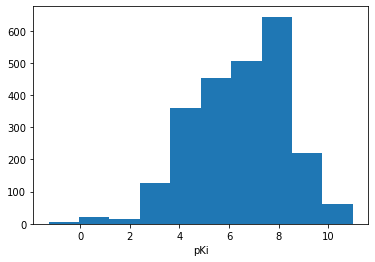

In [19]:
plt.hist(-np.log10(all_ki_meas['Ki(nM)']*(1E-9)))
plt.xlabel('pKi')

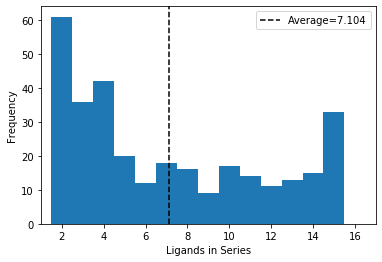

In [37]:
ki_avail_df_gp = all_ki_final.groupby('Receptor')
lig_counts = ki_avail_df_gp.count()['Ligand ID']
plt.hist(lig_counts,bins=np.arange(1,max(lig_counts),1),align='left')
plt.axvline(x=np.mean(lig_counts),label=f'Average={np.mean(lig_counts):.3f}',color='k',linestyle='--')
plt.xlabel('Ligands in Series')
plt.xlim([1,max(lig_counts)])
plt.ylabel('Frequency')
plt.legend()

### Kd is the least prevalent
Therefore we subset the whole frame to those ligands with Kd measurements

In [38]:
kd_avail_df = full_docked_df[full_docked_df['Kd(nM)'].notna()]

In [39]:
print('{} unique receptors'.format(len(kd_avail_df['Receptor'].unique())))
print('{} unique recptor-ligand pairs'.format(len(kd_avail_df.drop_duplicates(subset=['Receptor','Ligand ID']))))

218 unique receptors
662 unique recptor-ligand pairs


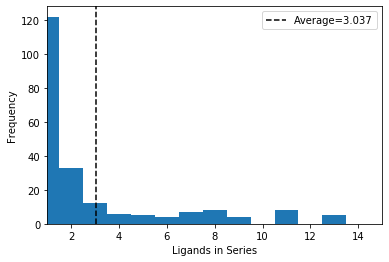

In [23]:
kd_rm_lig_gp = kd_avail_df.groupby('Receptor')
lig_counts = kd_rm_lig_gp.count()['Ligand ID']
plt.hist(lig_counts,bins=np.arange(1,max(lig_counts),1),align='left')
plt.axvline(x=np.mean(lig_counts),label=f'Average={np.mean(lig_counts):.3f}',color='k',linestyle='--')
plt.xlabel('Ligands in Series')
plt.xlim([1,max(lig_counts)])
plt.ylabel('Frequency')
plt.legend()

In [24]:
more_than_one_KD_bool = kd_avail_df['Kd(nM)'].apply(lambda x: len(str(x).split(';')) > 1)
kd_rm_mt1_meas = kd_avail_df[~more_than_one_KD_bool].copy()
kd_rm_mt1_meas['Kd(nM)'] = kd_rm_mt1_meas['Kd(nM)'].apply(lambda x: float(x.strip('><')) if isinstance(x,str) else x)
kd_mt1_meas = (kd_avail_df[more_than_one_KD_bool].reset_index())

## Getting the median 
kd_mt1_meas['Kd(nM)'] = kd_mt1_meas['Kd(nM)'].apply(lambda x: np.median([float(val.strip('><')) for val in x.split(';')]))

In [25]:
all_kd_meas = kd_rm_mt1_meas.append(kd_mt1_meas)
all_kd_meas = all_kd_meas.drop(all_kd_meas[all_kd_meas['Kd(nM)'] == 0].index)
all_kd_gp = all_kd_meas.groupby('Receptor')
all_kd_final = all_kd_gp.filter(lambda x: len(x) > 1) ## remove groups with less than 2 ligands


In [26]:
print(min(-np.log10(all_kd_meas['Kd(nM)']*(1E-9))),max(-np.log10(all_kd_meas['Kd(nM)']*(1E-9))))

1.6882461389442456 11.0


Text(0.5, 0, 'pKd')

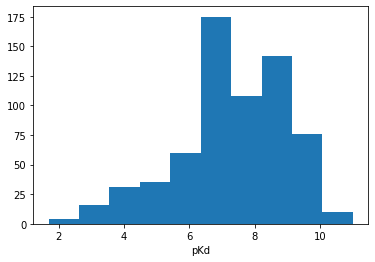

In [27]:
plt.hist(-np.log10(all_kd_meas['Kd(nM)']*(1E-9)))
plt.xlabel('pKd')

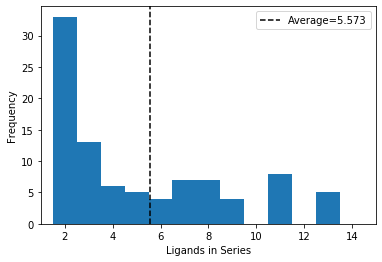

In [28]:
kd_rm_lig_gp = all_kd_final.groupby('Receptor')
lig_counts = kd_rm_lig_gp.count()['Ligand ID']
plt.hist(lig_counts,bins=np.arange(1,max(lig_counts),1),align='left')
plt.axvline(x=np.mean(lig_counts),label=f'Average={np.mean(lig_counts):.3f}',color='k',linestyle='--')
plt.xlabel('Ligands in Series')
plt.xlim([1,max(lig_counts)])
plt.ylabel('Frequency')
plt.legend()

In [29]:
## SEtting up the list of dataframes/measurments
meas_dfs= [(all_ic50_final,'IC50(nM)'),(all_ki_final,'Ki(nM)'),(all_kd_final,'Kd(nM)')]

## What about Receptors:
Only including receptors that have more than 1 ligand

In [30]:
meas_r_list = []
for df,meas in meas_dfs:
    meas_r_list.append(df['Receptor'].nunique())
#     print(f'Non-Nan {meas}:{meas_r_list[-1]}')

Text(0.5, -0.5, 'Covers 982 unique PDB IDs')

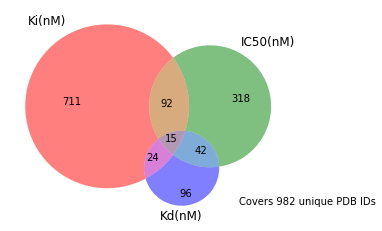

In [31]:
meas_recs = dict()
for df,meas in meas_dfs:
    meas_recs[meas]=set(df[df[meas].notna()].apply(lambda row: '{}'.format(row['Receptor']), axis=1).values.tolist())
total_overlap = len(meas_recs['Ki(nM)'].intersection(meas_recs['IC50(nM)'],meas_recs['Kd(nM)']))
ki_ic50_overlap = len(meas_recs['Ki(nM)'].intersection(meas_recs['IC50(nM)']))
ki_kd_overlap = len(meas_recs['Ki(nM)'].intersection(meas_recs['Kd(nM)']))
ic50_kd_overlap = len(meas_recs['Kd(nM)'].intersection(meas_recs['IC50(nM)']))

venn3(subsets = (meas_r_list[0], meas_r_list[1], ki_ic50_overlap, meas_r_list[2], ki_kd_overlap, ic50_kd_overlap, total_overlap), set_labels = ('Ki(nM)', 'IC50(nM)','Kd(nM)'), alpha = 0.5)
plt.annotate(f"Covers {len(meas_recs['Ki(nM)'].union(meas_recs['IC50(nM)'],meas_recs['Kd(nM)']))} unique PDB IDs",xy=(0.5,-0.5))

### Number of Ligands with each type of Measurement
Again only considering ligands of proteins that have more than 1 ligand associated

In [32]:
meas_list = []
for df,meas in meas_dfs:
    meas_list.append(len(df.drop_duplicates(subset=['Receptor','Ligand ID'])))
#     print(f'Non-Nan {meas}:{meas_list[-1]}')

Text(0.5, -0.5, 'Covers 8889 protein-ligand pairs')

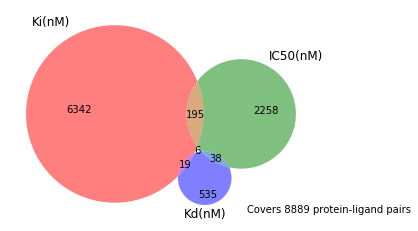

In [33]:
meas_ligs = dict()
for df,meas in meas_dfs:
    meas_ligs[meas]=set(df.apply(lambda row: '{}_{}'.format(row['Receptor'],row['Ligand ID']), axis=1).values.tolist())
total_overlap = len(meas_ligs['Ki(nM)'].intersection(meas_ligs['IC50(nM)'],meas_ligs['Kd(nM)']))
ki_ic50_overlap = len(meas_ligs['Ki(nM)'].intersection(meas_ligs['IC50(nM)']))
ki_kd_overlap = len(meas_ligs['Ki(nM)'].intersection(meas_ligs['Kd(nM)']))
ic50_kd_overlap = len(meas_ligs['Kd(nM)'].intersection(meas_ligs['IC50(nM)']))

venn3(subsets = (meas_list[0], meas_list[1], ki_ic50_overlap, meas_list[2], ki_kd_overlap, ic50_kd_overlap, total_overlap), set_labels = ('Ki(nM)', 'IC50(nM)','Kd(nM)'), alpha = 0.5)
plt.annotate(f"Covers {len(meas_ligs['Ki(nM)'].union(meas_ligs['IC50(nM)'],meas_ligs['Kd(nM)']))} protein-ligand pairs",xy=(0.5,-0.5))

# Dealing with values with more than 1 IC50 measurement
If we just toss them all out:

In [ ]:
more_than_one_IC50_bool = ic50_rm_lig['IC50(nM)'].apply(lambda x: len(str(x).split(';')) > 1)
ic50_rm_lig['IC50(nM)'] = ic50_rm_lig['IC50(nM)'].apply(lambda x: x.strip('><') if type(x) is str else x)
ic50_rm_mt1_meas = ic50_rm_lig[~more_than_one_IC50_bool].copy()
ic50_rm_mt1_meas['IC50(nM)'] = ic50_rm_mt1_meas['IC50(nM)'].astype(float)
ic50_rm_mt1_meas_gp = ic50_rm_mt1_meas.groupby('Receptor')
ic50_rm_lig_and_mt1 = ic50_rm_mt1_meas_gp.filter(lambda x: len(x) > 1) ## remove groups with less than 2 ligands
print('{} unique PDBIDs with greater than 1 ligand'.format(len(ic50_rm_lig_and_mt1['Receptor'].unique())))
print('{} unique receptor-ligand pairs'.format(len(ic50_rm_lig_and_mt1.drop_duplicates(subset=['Receptor','Ligand ID']))))

In [ ]:
print(f'{more_than_one_IC50_bool.sum()} ligands with multiple IC50 values')

In [ ]:
ic50_fin_gp = ic50_rm_lig_and_mt1.groupby('Receptor')
lig_counts = ic50_fin_gp.count()['Ligand ID']
plt.hist(lig_counts,bins=np.arange(1,max(lig_counts),1),align='left')
plt.axvline(x=np.mean(lig_counts),label=f'Average={np.mean(lig_counts):.3f}',color='k',linestyle='--')
plt.xlabel('Ligands in Series')
plt.xlim([1.5,max(lig_counts)])
plt.ylabel('Frequency')
plt.legend()

In [ ]:
ic50_range = -np.log10(ic50_fin_gp['IC50(nM)'].max()*(1E-9)) + np.log(ic50_fin_gp['IC50(nM)'].min()*(1E-9))
plt.hist(ic50_range,align='left')
plt.axvline(x=np.mean(ic50_range),label=f'Average={np.mean(ic50_range):.3f}',color='k',linestyle='--')
plt.xlabel('$pIC_{50}$ Range in Each Congeneric Series (nM)')
plt.xlim([1.5,max(ic50_range)])
plt.ylabel('Frequency')
plt.legend()

In [ ]:
import matplotlib.colors as mcolors 
ic50_mt1_meas = (ic50_rm_lig[more_than_one_IC50_bool].reset_index())
ic50_mt1_meas['split IC50(nM)'] = ic50_mt1_meas['IC50(nM)'].apply(lambda x: [float(val.strip('><')) for val in x.split(';')])
fig = plt.figure(figsize=[15,8])
colors = list(mcolors.BASE_COLORS.keys())
sum_range = 0
val_ranges = []
for idx, row in ic50_mt1_meas.iterrows():
    c = colors[idx % len(colors)]
    val_range=max(row['split IC50(nM)'])-min(row['split IC50(nM)'])
    plt.bar(idx,val_range,color=c)
    val_ranges.append(val_range)
    sum_range+= val_range
plt.hlines(sum_range/idx,0,idx,linestyles='--')
plt.annotate(f'{sum_range/idx:.2f}',(idx,sum_range/idx))
plt.ylabel('Range of $IC_{50}$ values (nM)')

In [ ]:
plt.hist([vals for vals in val_ranges if vals < 1E3 ],bins=100)

In [ ]:
len(val_ranges)

In [ ]:
for num in range(1,9):
    print(f'{len([vals for vals in val_ranges if vals < 1*10**(num)])}')

In [ ]:
sum_lens = 0
number_vals = [len(list_vals) for list_vals in ic50_mt1_meas['split IC50(nM)'].values.tolist()]
print(f'Avg Number of IC50 vals:{np.mean(number_vals)}\nMedian number:\t\t{np.median(number_vals)}\nMaximum number:\t\t{max(number_vals)}')
plt.hist(number_vals)
plt.xlabel('Number of $IC_{50}$ measurements for a protein-ligand pair')
plt.ylabel('Number of protein-ligand pairs')

# Setting up the dataset

In [45]:
receptors = set()
cong_series=set()
comparisons=0
for ms_df,measurement in meas_dfs:
    receptors = receptors.union(set(ms_df['Receptor'].unique().tolist()))
    ms_df['rec_ligscaff'] = ms_df['Structure File'].apply(lambda x: x.split('/')[-2])
    cong_series = cong_series.union(set([f"{val}_{measurement}" for val in ms_df['rec_ligscaff'].unique().tolist()]))
    comparisons += ms_df.groupby('rec_ligscaff')['Structure File'].count().apply(lambda x: math.factorial(x)/math.factorial(x-2) if x>=2 else 0).sum()

In [44]:
meas_dfs[0][0].groupby('rec_ligscaff')['Structure File'].count().apply(lambda x: math.factorial(x)/math.factorial(x-2) if x>=2 else 0).sum()

67016.0

In [47]:
print(len(receptors),len(cong_series),comparisons)

982 1140 91352.0


In [ ]:
## copy over the receptor file and ligand file
bad_files = []
for ms_df,measurement in meas_dfs:
    ms_df['Reference'] = 0
    ms_df['local file'] = ''
    for recdir, group in ms_df.groupby('rec_ligscaff'):
        max_tan = 0
        sf = None
        if not os.path.isdir(f"ddg_dataset/{recdir}"):
            os.mkdir(f"ddg_dataset/{recdir}")
        shutil.copyfile(f"BDB_docked/{recdir}/{recdir.split('_')[0]}.mol2",f"ddg_dataset/{recdir}/{recdir.split('_')[0]}.mol2")
        refmol = Chem.MolFromMolFile(f"BDB_docked/{recdir}/{recdir.split('_')[1]}.sdf",sanitize=False)
        if refmol is None:
            print(recdir)
            (obabel[f"BDB_docked/{recdir}/{recdir.split('_')[1]}.sdf","-O",f"BDB_docked/{recdir}/{recdir.split('_')[1]}_ob.sdf"])()
            refmol = Chem.MolFromMol2File(f"BDB_docked/{recdir}/{recdir.split('_')[1]}_ob.sdf",sanitize=False)
        ref_fp = Chem.RDKFingerprint(refmol)
        for idx, row in group.iterrows():
            filename = row['Structure File'].split('/')[-1]
            if os.path.isfile(f"BDB_docked/{recdir}/{filename}"):
                shutil.copyfile(f"BDB_docked/{recdir}/{filename}",f"ddg_dataset/{recdir}/{filename}")
            else:
                print(f"BDB_docked/{recdir}/{filename}")
                bad_files.append(row['Structure File'])
            compmol = Chem.MolFromMol2File(f"ddg_dataset/{recdir}/{filename}",sanitize=False)
            comp_fp = Chem.RDKFingerprint(compmol)
            Tan = DataStructs.TanimotoSimilarity(ref_fp,comp_fp)
            if Tan > max_tan: ## assigning the reference to the molecule with the highest Tanimoto Sim to the molecule used in the fragment docking
                max_tan = Tan
                sf = row['Structure File']
#         print(max_tan,ref_idx)
        ms_df.loc[ms_df['Structure File'] == sf,'Reference'] = 1

In [48]:
## Don't need to run this if you have already run the last cell
bad_files = []
for ms_df,measurement in meas_dfs:
    ms_df['Reference'] = 0
    ms_df['local file'] = ''
    for recdir, group in ms_df.groupby('rec_ligscaff'):
        max_tan = 0
        sf = None
        refmol = Chem.MolFromMolFile(f"BDB_docked/{recdir}/{recdir.split('_')[1]}.sdf",sanitize=False)
        if refmol is None:
            print(recdir)
            (obabel[f"BDB_docked/{recdir}/{recdir.split('_')[1]}.sdf","-O",f"BDB_docked/{recdir}/{recdir.split('_')[1]}_ob.sdf"])()
            refmol = Chem.MolFromMol2File(f"BDB_docked/{recdir}/{recdir.split('_')[1]}_ob.sdf",sanitize=False)
        ref_fp = Chem.RDKFingerprint(refmol)
        for idx, row in group.iterrows():
            filename = row['Structure File'].split('/')[-1]
            compmol = Chem.MolFromMol2File(f"ddg_dataset/{recdir}/{filename}",sanitize=False)
            comp_fp = Chem.RDKFingerprint(compmol)
            Tan = DataStructs.TanimotoSimilarity(ref_fp,comp_fp)
            if Tan > max_tan: ## assigning the reference to the molecule with the highest Tanimoto Sim to the molecule used in the fragment docking
                max_tan = Tan
                sf = row['Structure File']
#         print(max_tan,ref_idx)
        ms_df.loc[ms_df['Structure File'] == sf,'Reference'] = 1

RDKit WARNING: [12:31:08] BindingDB_26991: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [12:31:08] BindingDB_50278322: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [12:31:08] BindingDB_26991: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [12:31:08] BindingDB_50278322: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [12:31:08] BindingDB_26991: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [12:31:08] BindingDB_50278322: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [12:31:08] BindingDB_26992: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [12:31:08] BindingDB_26991: Warning - no explicit hydrogens in mol2 file 

No bad files!

In [51]:
randos=[0,1,2,3,4]
trainfile_names = [f'all_data_train_papersplit_rand{rand}_p' for rand in randos]
testfile_names = [f'all_data_test_papersplit_rand{rand}_p' for rand in randos]
for i,random in enumerate(randos):
    for addnl in range(1,7):
        trainfile = pd.DataFrame(columns=['class','reg','dg_lig1','dg_lig2','rec','lig1','lig2'])
        testfile = pd.DataFrame(columns=['class','reg','dg_lig1','dg_lig2','rec','lig1','lig2'])
        for ms_df,measurement in meas_dfs:
            ms_df.reset_index(drop=True,inplace=True)
            ms_df['fname'] = ms_df['Structure File'].apply(lambda x: x.split('/')[-1])
            for rec, group in ms_df.groupby('rec_ligscaff'):
                traingroupinfo=[]
                testgroupinfo=[]
                if not group['Reference'].sum(): ## have to make sure there is one reference structure per group (arbitrarily assigning the reference to the first row if it isn't already assigned)
                    print(rec)
                    continue
                if len(group)-1 < addnl:
                    train_group = pd.concat([group[(group['Reference'] == 1)],group[(group['Reference'] == 0)].sample(n=len(group)-1,random_state=random)])
                else:
                    train_group = pd.concat([group[(group['Reference'] == 1)],group[group['Reference'] == 0].sample(n=addnl,random_state=random)])
                ## Training set first
                for row1,row2 in list(permutations(train_group.index,2)):
                    pmeas1 = -np.log10(group.loc[row1,measurement]*(1E-9)) ##all measurements in nM
                    pmeas2 = -np.log10(group.loc[row2,measurement]*(1E-9))
                    dif = float(pmeas1) - float(pmeas2)
                    if dif == np.inf or dif == -np.inf or math.isnan(dif):
                        continue
                    try:
                        cls = int(float(pmeas1) > float(pmeas2))
                    except:
                        print(train_group)
                        break
                    dg_lig1 = float(pmeas1)
                    dg_lig2 = float(pmeas2)
                    receptor = f"{group.loc[row1,'rec_ligscaff']}/{group.loc[row1,'Receptor']}_0.gninatypes"
                    lig1 = f"{group.loc[row1,'rec_ligscaff']}/{group.loc[row1,'fname'].split('.')[0]}_0.gninatypes"
                    lig2 = f"{group.loc[row2,'rec_ligscaff']}/{group.loc[row2,'fname'].split('.')[0]}_0.gninatypes"
                    traingroupinfo.append([cls,dif,dg_lig1,dg_lig2,receptor,lig1,lig2])
                # Test set. Using idea that can only compare to values that are in the training set (i.e. 'Known' values)
                for row1,row2 in list(permutations(group.index,2)):
                    if not (bool(row1 in train_group.index) ^ bool(row2 in train_group.index)): ##supposed to be xor
                        continue
                    pmeas1 = -np.log10(group.loc[row1,measurement]*(1E-9)) ##all measurements in nM
                    pmeas2 = -np.log10(group.loc[row2,measurement]*(1E-9))
                    dif = float(pmeas1) - float(pmeas2)
                    if dif == np.inf or dif == -np.inf or math.isnan(dif):
                        continue
                    dg_lig1 = float(pmeas1)
                    dg_lig2 = float(pmeas2)
                    cls = int(float(pmeas1) > float(pmeas2))
                    receptor = f"{group.loc[row1,'rec_ligscaff']}/{group.loc[row1,'Receptor']}_0.gninatypes"
                    lig1 = f"{group.loc[row1,'rec_ligscaff']}/{group.loc[row1,'fname'].split('.')[0]}_0.gninatypes"
                    lig2 = f"{group.loc[row2,'rec_ligscaff']}/{group.loc[row2,'fname'].split('.')[0]}_0.gninatypes"
                    testgroupinfo.append([cls,dif,dg_lig1,dg_lig2,receptor,lig1,lig2])
                group_df = pd.DataFrame(data=traingroupinfo,columns=['class','reg','dg_lig1','dg_lig2','rec','lig1','lig2'])
                trainfile = trainfile.append(group_df,ignore_index=True)
                tgroup_df = pd.DataFrame(data=testgroupinfo,columns=['class','reg','dg_lig1','dg_lig2','rec','lig1','lig2'])
                testfile = testfile.append(tgroup_df,ignore_index=True)
        trainfile.to_csv(f'{trainfile_names[i]}_{addnl}.types',header=False,index=False,sep=' ',float_format='%.4f')
        testfile.to_csv(f'{testfile_names[i]}_{addnl}.types',header=False,index=False,sep=' ',float_format='%.4f')

In [52]:
## Make a master file containing all pairs
masterfile = pd.DataFrame(columns=['class','reg','dg_lig1','dg_lig2','rec','lig1','lig2'])
for ms_df,measurement in meas_dfs:
    ms_df.reset_index(drop=True,inplace=True)
    ms_df['fname'] = ms_df['Structure File'].apply(lambda x: x.split('/')[-1])
    for rec, group in ms_df.groupby('rec_ligscaff'):
        groupinfo=[]
        for row1,row2 in list(permutations(group.index,2)):
            pmeas1 = -np.log10(group.loc[row1,measurement]*(1E-9)) ##all measurements in nM
            pmeas2 = -np.log10(group.loc[row2,measurement]*(1E-9))
            dif = float(pmeas1) - float(pmeas2)
            if dif == np.inf or dif == -np.inf or math.isnan(dif):
                continue
            try:
                cls = int(float(pmeas1) > float(pmeas2))
            except:
                print(train_group)
                break
            dg_lig1 = float(pmeas1)
            dg_lig2 = float(pmeas2)
            receptor = f"{group.loc[row1,'rec_ligscaff']}/{group.loc[row1,'Receptor']}_0.gninatypes"
            lig1 = f"{group.loc[row1,'rec_ligscaff']}/{group.loc[row1,'fname'].split('.')[0]}_0.gninatypes"
            lig2 = f"{group.loc[row2,'rec_ligscaff']}/{group.loc[row2,'fname'].split('.')[0]}_0.gninatypes"
            groupinfo.append([cls,dif,dg_lig1,dg_lig2,receptor,lig1,lig2])
        group_df = pd.DataFrame(data=groupinfo,columns=['class','reg','dg_lig1','dg_lig2','rec','lig1','lig2'])
        masterfile = masterfile.append(group_df,ignore_index=True)
masterfile.to_csv(f'all_newdata.types',header=False,index=False,sep=' ',float_format='%.4f')

## PFAM Clustering

In [53]:
pdb_pfam = pd.read_csv('/home/anm329/DDG/DDG/pdb_pfam_mapping.txt', sep='\t',usecols=[0,1,4,5])
has_pfam = set(pdb_pfam.PDB_ID.unique().tolist())

In [54]:
missing = receptors - has_pfam
print(missing)

{'2H7I', '2H7P', '2H7N', '2H7M', '2H7L'}


In [55]:
pfam_receptors = set(receptors)

Just a case of obsolete PDBIDs

In [56]:
for ms_df, _ in meas_dfs:
    ms_df['pfam_PDBIDs'] = ms_df['Receptor']
    relev_pdbids = ms_df['Receptor'].unique().tolist()
    for rec in missing:
        if not (rec in relev_pdbids):
            continue
        response = requests.get('https://www.rcsb.org/structure/{}'.format(rec))
        soupyness = BeautifulSoup(response.content, 'html.parser')
        newlig= soupyness.find(id='note_obsoletedBy')
        newreceptor = newlig.find(href=re.compile('/structure/')).text
        print(f'{rec}:{newreceptor}')
        assert newreceptor in has_pfam
        ms_df.loc[ms_df.Receptor == rec,'pfam_PDBIDs'] = newreceptor
        pfam_receptors.remove(rec)
        pfam_receptors.add(newreceptor)
        

2H7I:4U0J
2H7P:4TZT
2H7N:4U0K
2H7M:4TZK
2H7L:4TRJ


In [57]:
relevant_pfams = pdb_pfam[pdb_pfam['PDB_ID'].isin(pfam_receptors)]
print(len(relevant_pfams),len(relevant_pfams.PFAM_Name.unique()))

1316 162


In [61]:
def getDataFrame(information, measurement):
    ## Uses permutations and gets absolute binding affinity information
    information_list = []
    for rec, group in information.groupby('rec_ligscaff'):
        for idx1, idx2 in list(permutations(group.index,2)):
            assert group.loc[idx1,'rec_ligscaff'] == group.loc[idx2,'rec_ligscaff']
            pmeas1 = -np.log10(group.loc[idx1,measurement]*(1E-9)) ##all measurements in nM
            pmeas2 = -np.log10(group.loc[idx2,measurement]*(1E-9))
            regression = float(pmeas1) - float(pmeas2)
            if regression == np.inf or regression == -np.inf or math.isnan(regression):
                        continue
            try:
                classification = int(float(pmeas1) > float(pmeas2))
            except:
                print(group)
                break
            dg_lig1 = float(pmeas1)
            dg_lig2 = float(pmeas2)
            receptor = f"{group.loc[idx1,'rec_ligscaff']}/{group.loc[idx1,'Receptor']}_0.gninatypes"
            lig1 = f"{group.loc[idx1,'rec_ligscaff']}/{group.loc[idx1,'fname'].split('.')[0]}_0.gninatypes"
            lig2 = f"{group.loc[idx2,'rec_ligscaff']}/{group.loc[idx2,'fname'].split('.')[0]}_0.gninatypes"
            information_list.append([classification, regression, dg_lig1, dg_lig2, receptor,lig1,lig2])
    return pd.DataFrame(information_list,columns=['class','reg','dg_lig1','dg_lig2','rec','lig1','lig2'])

In [ ]:
uniq_pfams = pd.Series(relevant_pfams['PFAM_Name'].unique().tolist())
value_to_PFAM = dict()
counter = 0
for value in range(len(uniq_pfams)):
    training_set_df = pd.DataFrame(columns=['class','reg','dg_lig1','dg_lig2','rec','lig1','lig2'])
    testing_set_df = pd.DataFrame(columns=['class','reg','dg_lig1','dg_lig2','rec','lig1','lig2'])
    for ms_df, meas in meas_dfs:
        training_pfam = uniq_pfams.drop(value)
        training_pdbids = relevant_pfams[relevant_pfams['PFAM_Name'].isin(training_pfam)]['PDB_ID'].unique()
        testing_set = ms_df[~ms_df['pfam_PDBIDs'].isin(training_pdbids)]
        training_set = ms_df[ms_df['pfam_PDBIDs'].isin(training_pdbids)]
        training_set_df = training_set_df.append(getDataFrame(training_set,meas))
        testing_set_df = testing_set_df.append(getDataFrame(testing_set,meas))
        assert len(set(training_set_df.rec.unique().tolist()).intersection(set(testing_set_df.rec.unique().tolist()))) == 0
    if not len(testing_set_df):
            continue
    value_to_PFAM[counter] = uniq_pfams[value]
    training_set_df.to_csv(f'PFAM_CV/train_pfam_cv_{counter}.types',sep=' ', header=False,index=False)
    testing_set_df.to_csv(f'PFAM_CV/test_pfam_cv_{counter}.types',sep=' ', header=False,index=False)
    counter += 1

In [ ]:
with open('pfam_values_map.txt','w') as outfile:
    outfile.write(f'Number Test_PFAM\n')
    for k, value in value_to_PFAM.items():
        outfile.write(f'{k} {value}\n')

### May need to de-duplicate the ligands
Not sure why, but some of the ligands for a receptor are the same molecule with a slightly different conformation

In [ ]:
check_directories = []
for directory in glob('ddg_dataset/*_*'):
    file_list = glob(f"{directory}/*-results_*.mol2")
    inchi_list = []
    for molfile in glob(f"{directory}/*-results_*.mol2"):
        inchi_list.append(Chem.MolToSmiles(Chem.MolFromMol2File(molfile,sanitize=False),canonical=True))
    if len(set(inchi_list)) != len(file_list):
#         print(f"{directory.split('/')[-1]}")
        check_directories.append(f"{directory.split('/')[-1]}")

In [ ]:
inchi_dict = dict()
for molfile in glob(f"ddg_dataset/{check_directories[0]}/*-results_*.mol2"):
        inchi_dict[molfile] = Chem.MolToSmiles(Chem.MolFromMol2File(molfile,sanitize=False),canonical=True)

In [ ]:
setOfElems = set()
for key, elem in inchi_dict.items():
    if elem in setOfElems:
        print(key)
    else:
        setOfElems.add(elem)         

In [ ]:
print([k for k,v in inchi_dict.items() if v == inchi_dict['ddg_dataset/3AYK_CGS/3AYK-results_11355.mol2']])

# Build several new sets
These sets will consist of a random sample of the ligands with multiple values
This will allow the building of an ensemble of models which can produce both a mean and variance to show the likelihood of the prediction being correct

Only going to use IC50 values for now to check if the ensembling idea works successfully

In [ ]:
## Try to create a random split
for rec, group in ic50_rm_mt1_meas.groupby('Receptor'):
    print(rec)
    # check if the receptor has any ligands with more than 1 IC50 measurement
    rec_mt1_meas = ic50_mt1_meas[ic50_mt1_meas['Receptor'] == rec]
    if len(rec_mt1_meas):
        print(f'{rec} has {len(rec_mt1_meas)} with more than 1 meas')

In [ ]:
ic50_mt1_meas[ic50_mt1_meas['Receptor'] == '11GS']

In [ ]:
for idx, lig in ic50_mt1_meas[ic50_mt1_meas['Receptor'] == '11GS'].iterrows():
    print(len(lig['split IC50(nM)']))
    choice = np.random.choice(range(len(lig['split IC50(nM)'])),1).item()
    print([lig['Compound'],lig['Structure File'],lig['split IC50(nM)'][choice],lig['Receptor'],lig['Ligand ID']])
#     print(lig['split IC50(nM)'][choice])

In [ ]:
test_mt1 = ic50_mt1_meas[ic50_mt1_meas['Receptor'] == '1AO8']
choice = np.random.choice(test_mt1['split IC50(nM)'].str.len)

In [ ]:
test_mt1['split IC50(nM)'].str.len().values